<a href="https://colab.research.google.com/github/vagabondboffin/EDAProject/blob/main/DAProject_May7th.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import scipy.stats as st
from sklearn import preprocessing
import matplotlib.pyplot as plt
import math

In [ ]:
data = pd.read_csv('transactionsSel.csv',engine='python')
#sort by date (not a required step since it will be automaticely done in most applications.)
data['instance_date'] = pd.to_datetime(data['instance_date'], dayfirst = True)
data["instance_date"] = data["instance_date"].astype('datetime64[ns]')
data.sort_values(by='instance_date', inplace = True)

# a) Adjusting prices for inflation rate

I found annual inflation rates from this link:
https://www.statista.com/statistics/297779/uae-inflation-rate/

We must indexed our data to the last year prices. I’m using the last data value to create the index, so that prices will be indexed to today’s prices. Indexed inflations are stored in 'CPI_Multiplier' column. Since our data is annual (I couldn't find monthly inflation rates/CPIs), I merged inflation data and transaction data by 'year'. Adjusted prices are in adjMeterPrice column.

The decreasing trend in inflation rates for some following years results in negative values for adjusted prices. This suggests that when considering the inflation, prices have actually dropped. 

In [ ]:
inflationRate = pd.read_csv('inflationRate.csv',engine='python')
inflationRate['CPI_Multiplier'] = inflationRate['rate'].iloc[-1] / inflationRate['rate']
data = pd.merge(data, inflationRate, how='left', on='year')
data['adjMeterPrice'] = data['meter_sale_price'] * data['CPI_Multiplier']

# b) Separate dataset by transaction types 

Previously, id and arabic columns were dropped. 

In [ ]:
data.keys()

Index(['Unnamed: 0_x', 'trans_group_en', 'procedure_name_en',
       'property_type_en', 'property_sub_type_en', 'property_usage_en',
       'reg_type_en', 'area_name_en', 'building_name_en', 'project_name_en',
       'master_project_en', 'nearest_landmark_en', 'nearest_metro_en',
       'nearest_mall_en', 'rooms_en', 'has_parking', 'procedure_area',
       'actual_worth', 'meter_sale_price', 'no_of_parties_role_1',
       'no_of_parties_role_2', 'no_of_parties_role_3', 'year', 'month',
       'meter_rent_price', 'instance_date', 'Unnamed: 0_y', 'rate',
       'CPI_Multiplier', 'adjMeterPrice'],
      dtype='object')

In [ ]:
#data = data.iloc[: , 1:]
data.drop(columns = ['Unnamed: 0_x', 'Unnamed: 0_y', 'CPI_Multiplier', 'rate', 'CPI_Multiplier'], inplace = True)

In [23]:
def subsetting(dataset, featureName, featureValue):
  subdataset = dataset[dataset[featureName] == featureValue]
  return subdataset


def findLessDiverseFeatures(dataset, boundry = 50):
  lessDiverseCols = []
  moreDiverseCols = []
  for column in dataset:
    numRow = dataset.shape[0]
    print(f'attribute name: {column}')
    row = dataset[column]
    print(f' number of missing values: {numRow - row.count()}')
    #print(f' percentage of missing values: {(numRow - row.count()) / numRow}')
    print(f' number of unique values: {row.nunique()}')
    print('+++++++++++++++++++++++++++++++++++++++++++++')
    if row.nunique() < boundry:
      if row.nunique() <= 10:
        lessDiverseCols.append(column)
      else:
        moreDiverseCols.append(column)
  lessDiverseCols.remove('trans_group_en')
  #lessDiverseCols.remove('meter_rent_price')
  return lessDiverseCols, moreDiverseCols

def piechartDistro(dataset, featureName):
  df = dataset.groupby([featureName])[featureName].count().reset_index(name='count')
  fig = px.pie(df, values='count', names=featureName, title=f"{featureName} Distribution")
  fig.show()

def histogramDistro(dataset, featureName):
  viz = sns.histplot(data = dataset, x = featureName, kde = True)
  viz.set_xticklabels(viz.get_xticklabels(), rotation = 90)
  plt.show()

## Sales subdataset


In [ ]:
dfSales = subsetting(data, 'trans_group_en','Sales')
lessDiverseCols, moreDiverseCols = findLessDiverseFeatures(dfSales)

In [ ]:
for i, feature in enumerate(moreDiverseCols):
  plt.figure(i)
  histogramDistro(dfSales, feature)

In [ ]:
for feature in lessDiverseCols:
  piechartDistro(dfSales, feature)

## Gifts subdataset


In [ ]:
dfGifts = subsetting(data, 'trans_group_en', 'Gifts')
lessDiverseCols, moreDiverseCols = findLessDiverseFeatures(dfGifts)


In [ ]:
for i, feature in enumerate(moreDiverseCols):
  plt.figure(i)
  histogramDistro(dfGifts, feature)

In [ ]:
for feature in lessDiverseCols:
  piechartDistro(dfGifts, feature)

## Mortgages subdataset


In [ ]:
dfMortgages = subsetting(data, 'trans_group_en', 'Mortgages')
lessDiverseCols, moreDiverseCols = findLessDiverseFeatures(dfMortgages)

In [ ]:
for i, feature in enumerate(moreDiverseCols):
  plt.figure(i)
  histogramDistro(dfMortgages, feature)

In [ ]:
for feature in lessDiverseCols:
  piechartDistro(dfMortgages, feature)

In [ ]:
x = dfSales[['meter_sale_price','adjMeterPrice']].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
normalized_prices = pd.DataFrame(x_scaled)

# c) Building Name and Area Name Related Tasks

Considerin the description of attributes (in the given files), I selected unit related and area related attributes as listed in the next cell.  

In [ ]:
unitRelatedFeatures = ['property_type_en', 'property_sub_type_en', 'property_usage_en', 
                       'rooms_en', 'has_parking', 'procedure_area']
areaRelatedFeatures = ['area_name_en', 'nearest_landmark_en', 'nearest_metro_en', 'nearest_mall_en',
                       'building_name_en'] #not very sure by picking building name!

Since the number of unique building and areas are more that it would be inconvenient to list the variations here. So all the requested results fro this part of the project are saved in .csv files in "reporting files" folder. 

Reported files are as follows:

"**building**_stats.csv" : among all categories of transactions 

"sales_building_stats.csv" : only for sales subdataset

"gifts_building_stats.csv" : only for gifts subdataset

"mortgages_building_stats.csv" : only for mortgages subdataset


"**area**_stats.csv" : among all categories of transactions

"sales_area_stats.csv" : only for sales subdataset

"gifts_area_stats.csv" : only for gifts subdataset

"mortgages_area_stats.csv" : only for mortgages subdataset

In [ ]:
print(f'number of unique buildings: {data.building_name_en.nunique()}')
print(f'number of unique areas: {data.area_name_en.nunique()}')

number of unique buildings: 3362
number of unique areas: 251


In [24]:
def calculateStats(dataset, groupbyName):
  stats = data.groupby([groupbyName])['meter_sale_price'].agg(['mean', 'count', 'std'])
  ci95_hi = []
  ci95_lo = []

  for i in stats.index:
      m, c, s = stats.loc[i]
      ci95_hi.append(m + 1.96*s/math.sqrt(c))
      ci95_lo.append(m - 1.96*s/math.sqrt(c))

  stats['ci95_hi'] = ci95_hi
  stats['ci95_lo'] = ci95_lo
  stats = stats.round(2)
  stats.sort_values(by='count', ascending = False, inplace = True)
  return stats

In [ ]:
#building name related stats for each subdataset
salesBuildingStats = calculateStats(dfSales, 'building_name_en')
salesBuildingStats.to_csv('sales_building_stats.csv')
giftsBuildingStats = calculateStats(dfGifts, 'building_name_en')
giftsBuildingStats.to_csv('gifts_building_stats.csv')
mortgagesBuildingStats = calculateStats(dfMortgages, 'building_name_en')
mortgagesBuildingStats.to_csv('mortgages_building_stats.csv')

#area name related stats for each subdataset
salesAreaStats = calculateStats(dfSales, 'area_name_en')
salesAreaStats.to_csv('sales_area_stats.csv')
giftsAreaStats = calculateStats(dfGifts, 'area_name_en')
giftsAreaStats.to_csv('gifts_area_stats.csv')
mortgagesAreaStats = calculateStats(dfMortgages, 'area_name_en')
mortgagesAreaStats.to_csv('mortgages_area_stats.csv')

# d) Model Training

This task is supposed to be done area-specific and building-specific. The details in the proposal were in some ways, regarding the requested prediction values, were confusing. So I took twwo approaches that sound logical. I tried to write the code in a way to alter it if the task was not fulfilled. 

As for evaluation metrics, f-score and confusion matrix are NOT very common and prefered metrics for regression problems. Since we are dealing with continuous prediction values, we have to look for evaluation metrics based on error calcualrion. RMSE and MAE are the most common evaluation metrics for regressors. 

One logical approach would be to create subdatasets for each and every area, and train the model for each subdataset separately. Since there are many unique values for buildings and areas, I perform this for the two most repeated areas but the procedure can easily be done for other areas.

I implemented this task on three different dataset scenarios. The results are not yet promising.

**Note**: prediction results for this section are presented in "regressionResults.pdf" file. 

In [ ]:
regressionReport = pd.DataFrame()


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost.sklearn import XGBRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.neural_network import MLPRegressor

In [26]:
def prediction_(data, area_or_building, regressor):
  attribute = 'area_name_en' if area_or_building == 'area' else 'building_name_en'
  featureset = areaRelatedFeatures if area_or_building == 'area' else unitRelatedFeatures
  thsh = 40000 if area_or_building == 'area' else 1100
  for item in data[attribute].unique():
    if data[attribute].value_counts()[item] > thsh:
      print('-'*30)
      print(f'results for applying {regressor} on {item}: ')
      subdataset = subsetting(data, attribute, item)
      X = subdataset[featureset]
      X = pd.get_dummies(X)
      y = subdataset['meter_sale_price']
      Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2)
      ytrain = np.array(ytrain).reshape(-1, 1)
      ytest = np.array(ytest).reshape(-1, 1)

      #print(ytrain.mean())
      #print(ytest.mean())
      RMSE, MAE = Regression_(Xtrain, ytrain, Xtest, ytest, regressor)


In [27]:
def Regression_(Xtrain, Ytrain, Xtest, Ytest, classifier):
    #sc = StandardScaler()
    #Ytrain = sc.fit_transform(Ytrain)
    #Ytest = sc.transform(Ytest)

    Xtrain = np.array(Xtrain)
    Ytrain = np.array(Ytrain)

    Xtest = np.array(Xtest)
    Ytest = np.array(Ytest)

    if classifier == 'Linear Regression':
        model = LinearRegression()

    elif classifier == 'XGBoost':
        model = XGBRegressor()

    elif classifier == 'Stochastic Gradient Descent':
        model = SGDRegressor()

    elif classifier == 'Neural Network':
        model = MLPRegressor()

    elif classifier == 'Random Forest':
        model = RandomForestRegressor(n_estimators = 100)

    model.fit(Xtrain, Ytrain)
    expected = Ytest
    predicted = model.predict(Xtest)
    RMSE = np.sqrt(mean_squared_error(expected, predicted))
    MAE = mean_absolute_error(expected, predicted)
    print("The Mean Absolute Error of our Model is {}".format(round(MAE, 2)))
    print("The Root Mean Squared Error of our Model is {}".format(round(RMSE, 2)))
    return RMSE, MAE



In [28]:
q = data.meter_sale_price.quantile(.92)
data = data[data['meter_sale_price']<q]

In [ ]:
prediction_(data, 'area', 'Linear Regression')
prediction_(data, 'area', 'XGBoost')
prediction_(data, 'area', 'Stochastic Gradient Descent')
prediction_(data, 'area', 'Random Forest')
prediction_(data, 'area', 'Neural Network')

# e) Fountain Views Buildings

**Note**: report for this part is presented in "FountainViewsReport.pdf" file.

In [119]:
#data = pd.read_csv('transactionsSel.csv',engine='python')
df = data.dropna(subset = "building_name_en")
df = df[df['building_name_en'].str.contains("Fountain Views")]

In [63]:
lessDiverse, moreDiverse = findLessDiverseFeatures(df, 50)

attribute name: Unnamed: 0
 number of missing values: 0
 number of unique values: 1898
+++++++++++++++++++++++++++++++++++++++++++++
attribute name: trans_group_en
 number of missing values: 0
 number of unique values: 3
+++++++++++++++++++++++++++++++++++++++++++++
attribute name: procedure_name_en
 number of missing values: 0
 number of unique values: 14
+++++++++++++++++++++++++++++++++++++++++++++
attribute name: property_type_en
 number of missing values: 0
 number of unique values: 1
+++++++++++++++++++++++++++++++++++++++++++++
attribute name: property_sub_type_en
 number of missing values: 0
 number of unique values: 2
+++++++++++++++++++++++++++++++++++++++++++++
attribute name: property_usage_en
 number of missing values: 0
 number of unique values: 2
+++++++++++++++++++++++++++++++++++++++++++++
attribute name: reg_type_en
 number of missing values: 0
 number of unique values: 2
+++++++++++++++++++++++++++++++++++++++++++++
attribute name: area_name_en
 number of missing val

In [120]:
for column in df:
  numRow = df.shape[0]
  if df[column].nunique() == 1:
    uniqueFeatures.append(column)
    df.drop(columns = column, inplace = True)

In [121]:
df.drop(columns = ['no_of_parties_role_1', 'no_of_parties_role_2', 
                   'no_of_parties_role_3','Unnamed: 0','instance_date'], inplace = True)

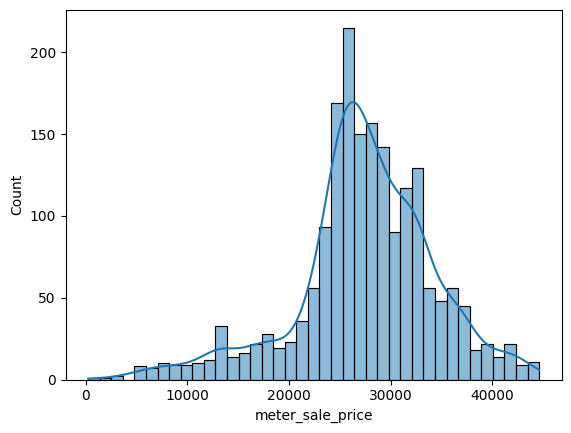

In [87]:
q = df.meter_sale_price.quantile(.99)
cleanDf = df[df['meter_sale_price']<q]
sns.histplot(data = cleanDf, x = 'meter_sale_price', kde = True);

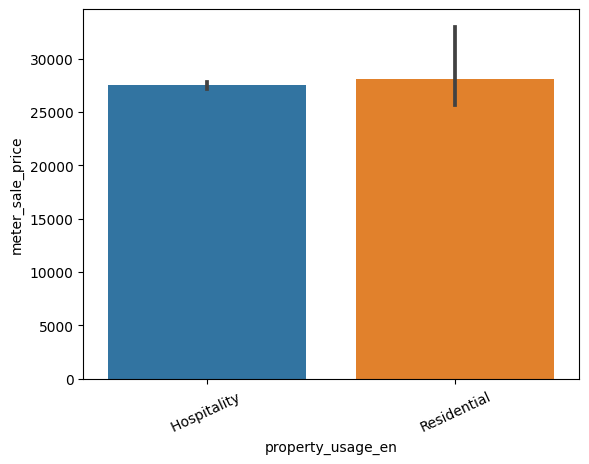

In [97]:
viz = sns.barplot(data = df, x = 'property_usage_en', y = 'meter_sale_price', estimator = np.median)
viz.set_xticklabels(viz.get_xticklabels(), rotation = 25)
plt.show()

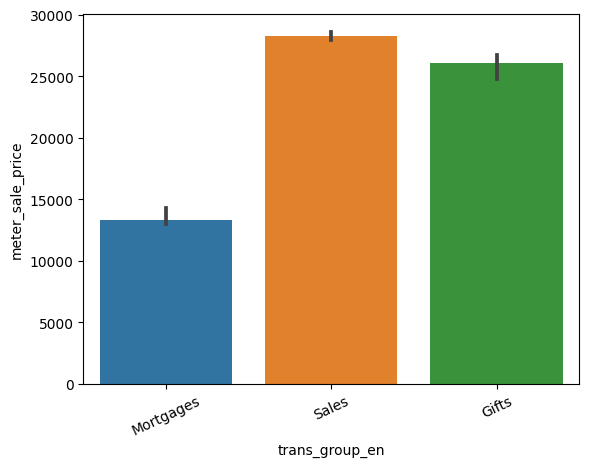

In [78]:
viz = sns.barplot(data = df, x = 'trans_group_en', y =rans_group_en 'meter_sale_price', estimator = np.median)
viz.set_xticklabels(viz.get_xticklabels(), rotation = 25)
plt.show()

In [ ]:
dfSales = subsetting(df, 'trans_group_en','Sales')
lessDiverseCols, moreDiverseCols = findLessDiverseFeatures(dfSales)
for i, feature in enumerate(moreDiverseCols):
  plt.figure(i)
  histogramDistro(dfSales, feature)
# for feature in lessDiverseCols:
#   piechartDistro(dfSales, feature)

In [73]:
dfGifts = subsetting(df, 'trans_group_en','Gifts')
# lessDiverseCols, moreDiverseCols = findLessDiverseFeatures(dfGifts)
# for i, feature in enumerate(moreDiverseCols):
#   plt.figure(i)
#   histogramDistro(dfGifts, feature)
# for feature in lessDiverseCols:
#   piechartDistro(dfGifts, feature)

In [74]:
dfMortgages = subsetting(df, 'trans_group_en','Mortgages')
# lessDiverseCols, moreDiverseCols = findLessDiverseFeatures(dfMortgages)
# for i, feature in enumerate(moreDiverseCols):
#   plt.figure(i)
#   histogramDistro(dfMortgages, feature)
# for feature in lessDiverseCols:
#   piechartDistro(dfMortgages, feature)

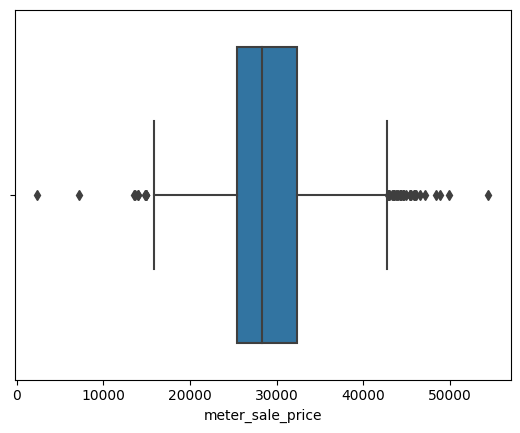

In [75]:
sns.boxplot(x = dfSales['meter_sale_price']);

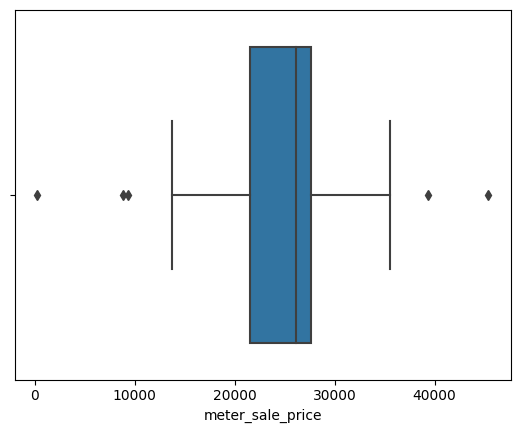

In [76]:
sns.boxplot(x = dfGifts['meter_sale_price']);


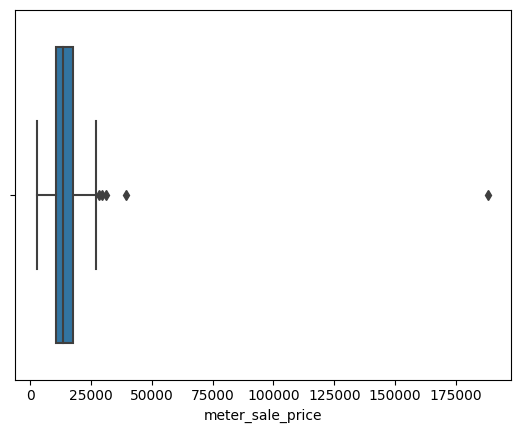

In [77]:
sns.boxplot(x = dfMortgages['meter_sale_price']);

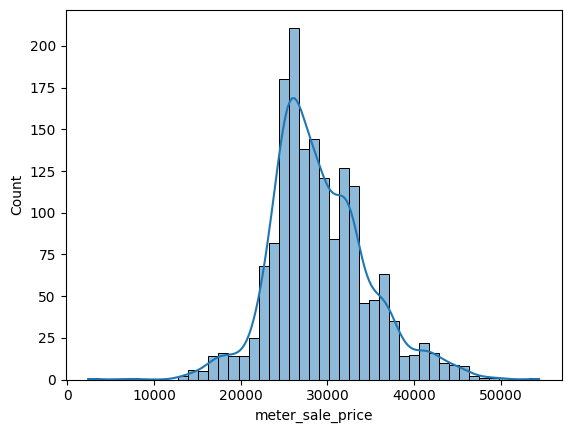

In [88]:
sns.histplot(data = dfSales, x = 'meter_sale_price', kde = True);

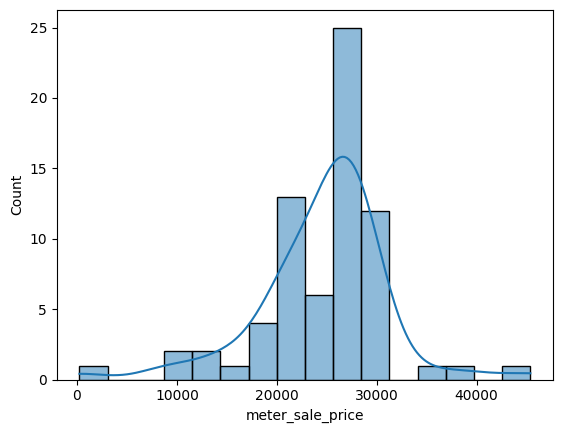

In [90]:
sns.histplot(data = dfGifts, x = 'meter_sale_price', kde = True);

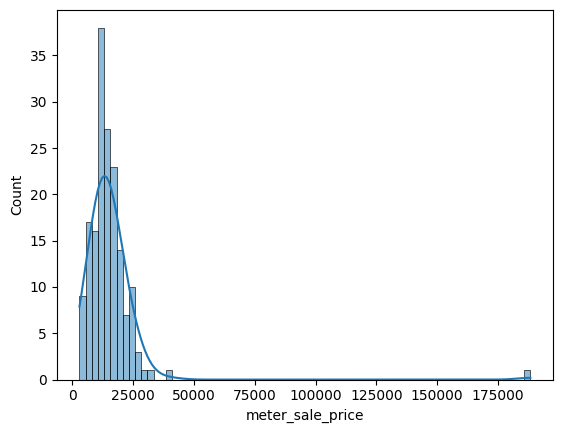

In [89]:
sns.histplot(data = dfMortgages, x = 'meter_sale_price', kde = True);

In [91]:
df.keys()

Index(['trans_group_en', 'procedure_name_en', 'property_sub_type_en',
       'property_usage_en', 'reg_type_en', 'building_name_en',
       'project_name_en', 'rooms_en', 'procedure_area', 'actual_worth',
       'meter_sale_price', 'year', 'month', 'meter_rent_price'],
      dtype='object')

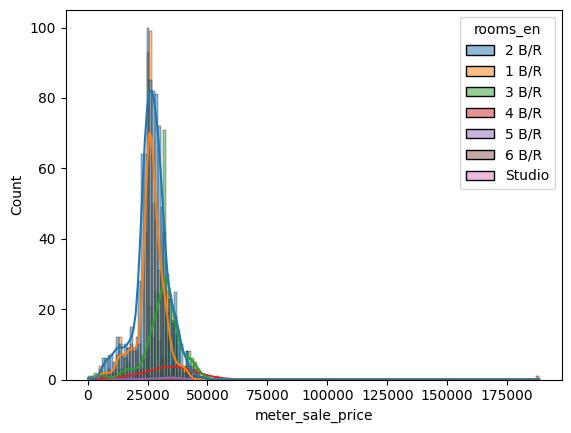

In [95]:
sns.histplot(data = df, x = 'meter_sale_price', hue = 'rooms_en', kde = True);

In [105]:
df.keys()

Index(['trans_group_en', 'procedure_name_en', 'property_sub_type_en',
       'property_usage_en', 'reg_type_en', 'building_name_en',
       'project_name_en', 'rooms_en', 'procedure_area', 'actual_worth', 'year',
       'month', 'meter_rent_price'],
      dtype='object')

In [126]:
for unq in np.unique(uniqueFeatures):
  print(unq)

area_name_en
has_parking
master_project_en
nearest_landmark_en
nearest_mall_en
nearest_metro_en
property_type_en
